# Postprocessing

We start by importing the `openmc` module, which contains the API to generate the input files for OpenMC.

In [1]:
import openmc
openmc.config['cross_sections'] = '/home/student/openmc_ncrystal_vm/endfb-viii.0-hdf5/cross_sections.xml'

We will also import numpy and matplotlib, to import the data and plot.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Statepoint files

As said in the previous section, at the end of the run OpenMC generates an HDF5 formatted file containing the results from the tallies and restart information. The defalut name for this file is `statepoint.XX.h5` where `XX` is the number of batches run in the simulation. 

This can be imported into the Python environment for postprocessing using the `Statepoint()` class. For instance, to import the statepoint file produced in the last run we can do:

In [3]:
sp = openmc.StatePoint('statepoint.10.h5')

The attribute `Statepoint.tallies` contains a dictionary with the tallies from the simulation:

In [4]:
print(type(sp.tallies))

<class 'dict'>


In [5]:
sp.tallies

{30: Tally
 	ID             =	30
 	Name           =	leakage
 	Filters        =	SurfaceFilter
 	Nuclides       =	total
 	Scores         =	['current']
 	Estimator      =	analog,
 31: Tally
 	ID             =	31
 	Name           =	absorption
 	Filters        =	CellFilter
 	Nuclides       =	total
 	Scores         =	['absorption']
 	Estimator      =	tracklength,
 32: Tally
 	ID             =	32
 	Name           =	spectrum
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength,
 33: Tally
 	ID             =	33
 	Name           =	mesh tally
 	Filters        =	MeshFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength}

The keys for the dictionary are the tally ids which might be hard to remember and are usually automatically generated. Instead, it is easier to access the tallies by name:

In [6]:
tal_leak = sp.get_tally(name='leakage')

In [7]:
tal_abs = sp.get_tally(name='absorption')

### Pandas dataframes

The most practical way to access the data inside of the tally is to export it as a [Pandas](https://pandas.pydata.org/) dataframe. This is a standard format for data analysis in Python:

In [8]:
leak_df = tal_leak.get_pandas_dataframe()

In [9]:
leak_df

,surface,nuclide,score,mean,std. dev.
0,1,total,current,0.59727,0.001353


Different columns can be accessed by their name. To get the actual values as numpy arrays we need to get the `df.values` attribute:

In [10]:
leak_df['mean']

0    0.59727
Name: mean, dtype: float64

In [11]:
leak_df['mean'].values

array([0.59727])

### Tally arithmetic

Tallies support arithmetic operations and propagate the statistical uncertainty:

In [12]:
tal_total = tal_leak + tal_abs

In [13]:
tal_total.get_pandas_dataframe()

,surface,cell,nuclide,score,mean,std. dev.
0,1,1,total,(current + absorption),0.997977,0.001869


### Example

The utility of this approach can be easily seen with more complex tallies. Let's start again with the same simple problem:

In [14]:
# Material definition

h2o = openmc.Material()
h2o.add_nuclide("H1", 2.0, "ao")
h2o.add_nuclide("O16", 1.0, "ao")
h2o.set_density("g/cm3", 1)
h2o.add_s_alpha_beta("c_H_in_H2O")

mats = openmc.Materials([h2o])
mats.export_to_xml()

# Geometry definition

sphere = openmc.Sphere(r=10, boundary_type="vacuum")
cell = openmc.Cell(region=-sphere, fill=h2o)
universe = openmc.Universe(cells=[cell])

geom = openmc.Geometry(universe)
geom.export_to_xml()

# Settings definition

source = openmc.Source()
source.space = openmc.stats.Point(xyz=(0.0, 0.0, 0.0))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([1.0e6], [1.0])

settings = openmc.Settings()
settings.source = source
settings.run_mode = "fixed source"
settings.batches = 10
settings.particles = 10000
settings.export_to_xml()

We will add two more tallies:

- One to compute the spectra of neutrons inside of the moderator cell.
- One to compute the spatial distribution of the neutrons in the cell.

In [15]:
tally1 = openmc.Tally(name='leakage')
tally1.scores=['current']
filter1 = openmc.SurfaceFilter(sphere)
tally1.filters = [filter1]

tally2 = openmc.Tally(name='absorption')
tally2.scores=['absorption']
filter2 = openmc.CellFilter(cell)
tally2.filters = [filter2]

tally3 = openmc.Tally(name='spectrum')
tally3.scores=['flux']
filter4 = openmc.EnergyFilter(np.geomspace(1e-4, 1e6, 201)) # Energy group limits: 200 groups between 0.1 meV and 10 MeV
tally3.filters = [filter2, filter4]

tally4 = openmc.Tally(name='mesh tally')
tally4.scores=['flux']
mesh1 = openmc.RectilinearMesh()
mesh1.x_grid = np.linspace(-10,10,21)
mesh1.y_grid = np.linspace(-10,10,21)
mesh1.z_grid = [-0.5,1]
filter5 = openmc.MeshFilter(mesh1) 
tally4.filters = [filter5]

tallies = openmc.Tallies([tally1, tally2, tally3, tally4])
tallies.export_to_xml()

In [16]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

### Plot the spectra

Let's open the statepoint file to postprocess the results:

In [17]:
sp = openmc.StatePoint('statepoint.10.h5')

In [18]:
tal_spectrum = sp.get_tally(name='spectrum')
df = tal_spectrum.get_pandas_dataframe()

In [19]:
df

,cell,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,2,0.000100,0.000112,total,flux,0.000044,0.000005
1,2,0.000112,0.000126,total,flux,0.000036,0.000007
2,2,0.000126,0.000141,total,flux,0.000059,0.000010
3,2,0.000141,0.000158,total,flux,0.000074,0.000008
4,2,0.000158,0.000178,total,flux,0.000089,0.000011
...,...,...,...,...,...,...,...
195,2,562341.325190,630957.344480,total,flux,0.282973,0.003977
196,2,630957.344480,707945.784384,total,flux,0.343413,0.002941
197,2,707945.784384,794328.234724,total,flux,0.662589,0.004180
198,2,794328.234724,891250.938134,total,flux,0.683177,0.005481


In [20]:
E_g = df['energy high [eV]'].values
phi_g = df['mean'].values

Text(0, 0.5, 'Group flux [part-cm]')

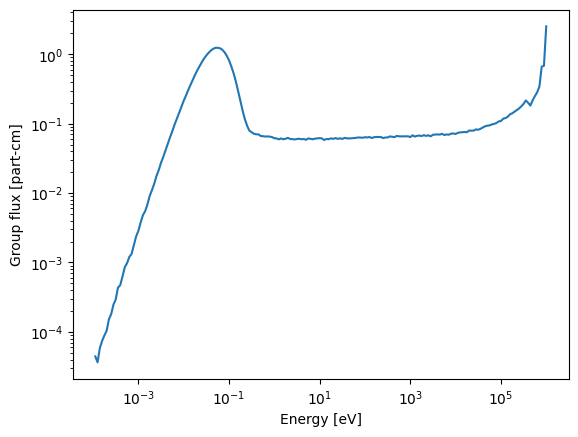

In [21]:
plt.loglog(E_g, phi_g)
plt.xlabel('Energy [eV]')
plt.ylabel('Group flux [part-cm]')

### Plot the mesh tally

Let's open the statepoint file to postprocess the results (this is not needed if we continue running from above):

In [22]:
sp = openmc.StatePoint('statepoint.10.h5')

In [23]:
tal_mesh = sp.get_tally(name='mesh tally')
df = tal_mesh.get_pandas_dataframe()

In [24]:
df

mesh 1        nuclide score     mean std. dev.
         x   y  z                                 
0        1   1  1   total  flux 0.00e+00  0.00e+00
1        2   1  1   total  flux 0.00e+00  0.00e+00
2        3   1  1   total  flux 0.00e+00  0.00e+00
3        4   1  1   total  flux 0.00e+00  0.00e+00
4        5   1  1   total  flux 0.00e+00  0.00e+00
..     ...  .. ..     ...   ...      ...       ...
395     16  20  1   total  flux 0.00e+00  0.00e+00
396     17  20  1   total  flux 0.00e+00  0.00e+00
397     18  20  1   total  flux 0.00e+00  0.00e+00
398     19  20  1   total  flux 0.00e+00  0.00e+00
399     20  20  1   total  flux 0.00e+00  0.00e+00

[400 rows x 7 columns]

We will extract the result and shape it to a 20x20 array:

In [25]:
values = df['mean'].values
values.shape = (20,20)

In order to plot the mesh tally we also need the mesh. This could be reused from the Python code above used to generate the tally, but if it is not available, we can extract it too from the tally:

In [26]:
mesh = tal_mesh.find_filter(openmc.MeshFilter)

In [27]:
xmesh = mesh.mesh.x_grid
ymesh = mesh.mesh.y_grid

Text(0, 0.5, 'y [cm]')

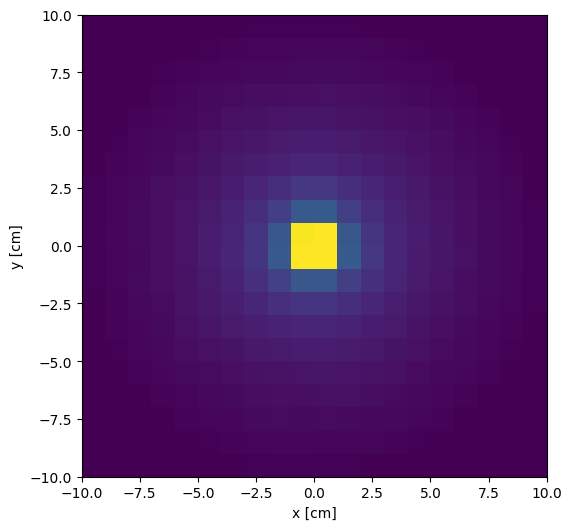

In [28]:
plt.figure(figsize=(6,6))
plt.pcolormesh(xmesh,ymesh,values)
plt.colormap()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')